In [2]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()

In [3]:
e_field = zero_field()
b_field = t89(0, 4.01172e7)
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-4        # Simulation time step
trials = 10          # Number of runs
steps  = int(T / dt) # Number of steps per run

min_x = -15

x_init_gsm = -4
y_init_gsm = 0
z_init_gsm = 1.85

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              delta(np.array([x_init_gsm * Re, y_init_gsm * Re, z_init_gsm * Re])),
                              delta(5e5),
                              delta(np.pi / 2),
                              uniform(0, 2 * np.pi)
                             )


solve(history, intrinsic, dt)

In [4]:
guiding_center = gca_filter(history, intrinsic, dt)
eq_pas = eq_pitch_angle(history)

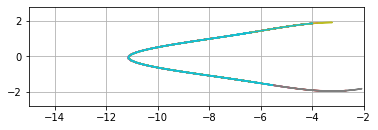

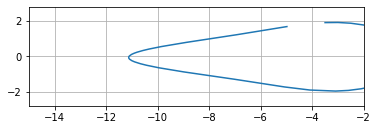

In [10]:
from geopack_numba.geopack import trace

plt.subplot(211)
for i in range(trials):
    plt.plot(history[i, :, 0, 0] / Re, history[i, :, 0, 2] / Re)

plt.xlim([min_x, 0.5 * x_init_gsm])
plt.ylim([-abs(1.5 * z_init_gsm), abs(1.5 * z_init_gsm)])
plt.grid()
plt.show()

plt.subplot(212)
x0, y0, z0, xx0, yy0, zz0 = trace(x_init_gsm, y_init_gsm, z_init_gsm, 1, 1000, parmod=0)
x1, y1, z1, xx1, yy1, zz1 = trace(x_init_gsm, y_init_gsm, z_init_gsm, -1, 1000, parmod=0)
plt.plot(xx0, zz0, color='C0')
plt.plot(xx1, zz1, color='C0')
plt.xlim([min_x, 0.5 * x_init_gsm])
plt.ylim([-abs(1.5 * z_init_gsm), abs(1.5 * z_init_gsm)])
plt.grid()

plt.show()

In [ ]:
@njit
def characterize_field_line(field, r, parmod=0):
    x_init_gsm = r[0] / Re
    y_init_gsm = r[1] / Re
    z_init_gsm = r[2] / Re

    x0, y0, z0, xx0, yy0, zz0 = trace(x_init_gsm, y_init_gsm, z_init_gsm, 1, 1000, parmod=0)
    x1, y1, z1, xx1, yy1, zz1 = trace(x_init_gsm, y_init_gsm, z_init_gsm, -1, 1000, parmod=0)
    
    xx = np.append(xx0, xx1)
    yy = np.append(yy0, yy1)
    zz = np.append(zz0, zz1)
    
    r_mag = np.zeros(len(xx))
    
    for i in range(len(xx0)):
        r_mag[i] = np.sqrt(xx[i]**2 + yy[i]**2 + zz[i]**2)
    
    ind_min = np.abs(r_mag - 1).argmin()
    ind_max = r_mag.argmax()
    
    field_min = np.linalg.norm(field(np.array([xx[ind_max] * Re, yy[ind_max] * Re, zz[ind_max] * Re])))
    field_max = np.linalg.norm(field(np.array([xx[ind_min] * Re, yy[ind_min] * Re, zz[ind_min] * Re])))
    
    return r_mag[ind_max], field_min, field_max

In [61]:
re_over_Re, b_min, b_max = characterize_field_line(b_field, np.array([-4 * Re, 0, 1.85 * Re]))
print(re_over_Re, np.degrees(np.arcsin(np.sqrt(b_min / b_max))))

11.126970775802908 0.8036239366306313


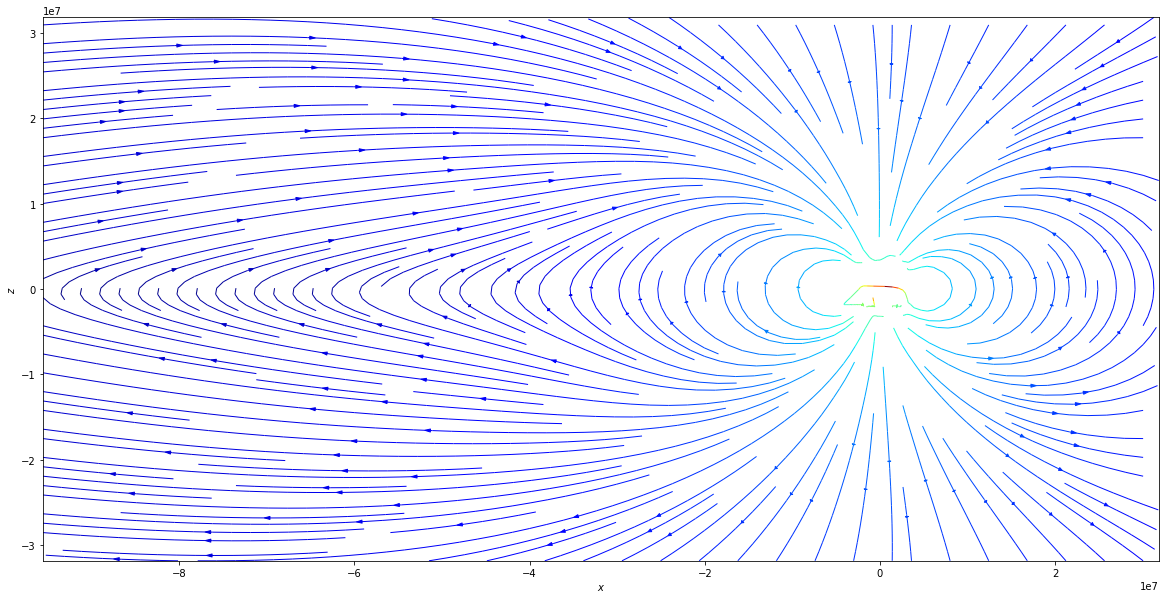

In [26]:
from diagnostics import *

@njit
def flc(field, r, eps):
    x_offset = np.array([eps, 0.0, 0.0])
    y_offset = np.array([0.0, eps, 0.0])
    z_offset = np.array([0.0, 0.0, eps])
    
    b = field(r)
    b /= np.linalg.norm(b)

    fx1 = field(r + x_offset)
    fx1 /= np.linalg.norm(fx1)
    
    fx0 = field(r - x_offset)
    fx0 /= np.linalg.norm(fx0)
    
    fy1 = field(r + y_offset)
    fy1 /= np.linalg.norm(fy1)
    
    fy0 = field(r - y_offset)
    fy0 /= np.linalg.norm(fy0)
    
    fz1 = field(r + z_offset)
    fz1 /= np.linalg.norm(fz1)
    
    fz0 = field(r - z_offset)
    fz0 /= np.linalg.norm(fz0)

    J = np.zeros((3, 3))
    J[:, 0] = (fx1 - fx0) / (2 * eps)
    J[:, 1] = (fy1 - fy0) / (2 * eps)
    J[:, 2] = (fz1 - fz0) / (2 * eps)
    
    return (1.0 / np.linalg.norm(np.dot(J, b))) / Re

plot_field(b_field, 'y', 50, [-15 * Re, 5 * Re], [-5 * Re, 5 * Re], (20, 10))

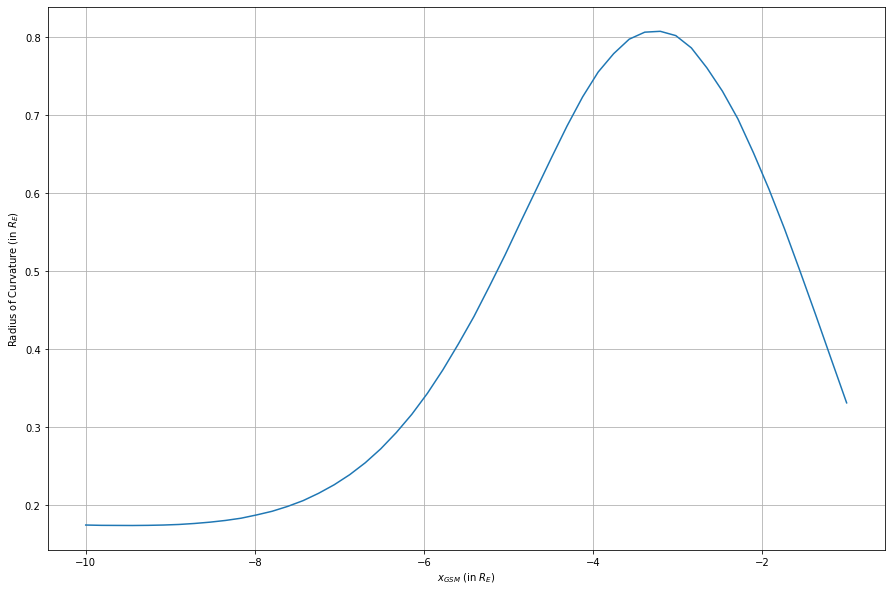

In [30]:
steps = 50
curvature_plt = np.zeros(steps)
radii = np.linspace(-10, -1, steps)

for i, j in enumerate(radii):
    curvature_plt[i] = flc(b_field, np.array([j * Re, 0, 0]), 1e-6)
    
plt.figure(figsize=(15, 10))
plt.plot(radii, curvature_plt)
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('Radius of Curvature (in $R_E$)')
plt.grid()
plt.show()

In [9]:
@njit
def gc_mag(gca):
    num_particles = len(gca[:, 0, 0])
    steps = len(gca[0, :, 0])
    
    history_new = np.zeros((num_particles, steps))
    
    for i in range(num_particles):
        for j in range(steps):
            history_new[i, j] = np.sqrt(dot(gca[i, j], gca[i, j]))
            
    return history_new

In [10]:
from scipy.signal import find_peaks

gcm = gc_mag(guiding_center)

In [11]:
eq_ang_all = []

for i in range(trials):
    #plt.plot(-gcm[i, :])
    #plt.show()

    indices = find_peaks(-gcm[i, :])[0]
    eq_angs = np.zeros(len(indices))
    
    for j, k in enumerate(indices):
        mirror_lat = np.arcsin(guiding_center[i, k, 2] / gcm[i, k])
        eq_pitch_ang_from_mirror_lat = np.sqrt(np.arcsin(np.cos(mirror_lat)**6 / np.sqrt(1 + 3 * np.sin(mirror_lat)**2)))
        eq_angs[j] = eq_pitch_ang_from_mirror_lat
        
    #plt.plot(-gcm[i, :])
    #plt.vlines(indices, low, high)
    #plt.show()
    
    eq_ang_all.append(np.degrees(eq_angs))

In [12]:
eq_pas[:, 3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
eq_ang_all

[array([63.50022347]),
 array([62.61369313]),
 array([36.98703187, 36.62820573]),
 array([36.98703212, 49.59821927]),
 array([36.98704199, 43.44405439]),
 array([36.98704196, 47.51634593]),
 array([36.98703977, 37.1615406 ]),
 array([63.38832491, 68.09427153]),
 array([61.95091741]),
 array([59.36603162, 69.39832873])]